<a href="https://colab.research.google.com/github/electronjia/heart_cardiac_mri_image_processing/blob/main/edge_detection_and_contours/lv_edge_detection_scrapbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mahri
I will use dicom images because they preserve accurate pixel spacing and temporal ordering that might be needed for ejection fraction and motion tracking.

In [ ]:
# On g collab only
!git clone https://github.com/electronjia/heart_cardiac_mri_image_processing.git

In [ ]:
# On g collab only
!pip install pydicom

In [ ]:
# On g collab only
!pwd
!ls -l
%cd heart_cardiac_mri_image_processing/edge_detection_and_contours
!pwd

In [266]:
import pandas as pd
from config import *
import os
import numpy as np
from skimage import exposure, filters, measure, morphology
import matplotlib.pyplot as plt
import pydicom
from skimage import img_as_ubyte
from skimage.feature import canny
from skimage.measure import label, regionprops
import ipywidgets as widgets
from IPython.display import display
from skimage.draw import polygon

In [ ]:
# On g collab only
import sys
sys.path.append('/content/heart_cardiac_mri_image_processing/edge_detection_and_contours')
user_handle = r"/content/heart_cardiac_mri_image_processing/data"
patient_data_excel_path = r"/content/heart_cardiac_mri_image_processing/scd_patientdata_xlsx.xlsx"
patient_data = "patient_data"
patient_filepaths = "patient_filepaths"

Read the excel file with patient filepaths to start processing

In [268]:
patient_xlsx = patient_data_excel_path
patient_data_df = pd.read_excel(patient_xlsx, sheet_name=patient_data)
patient_filepaths_df = pd.read_excel(patient_xlsx, sheet_name=patient_filepaths)

display(patient_data_df.head(2))
display(patient_filepaths_df.head(2))

,patient_id,original_id,gender,age,pathology,filepath,gif_filepath
0,SCD0000101,SC-HF-I-1,Male,53,Heart failure with infarct,SCD_IMAGES_01\SCD0000101\CINESAX_300,SCD_IMAGES_01\SCD0000101\SCD0000101_gif.gif
1,SCD0000201,SC-HF-I-2,Male,48,Heart failure with infarct,SCD_IMAGES_01\SCD0000201\CINESAX_300,SCD_IMAGES_01\SCD0000201\SCD0000201_gif.gif


,patient_id,dcm_image_filepath
0,SCD0000101,SCD_IMAGES_01\SCD0000101\CINESAX_300\IM-0003-0...
1,SCD0000101,SCD_IMAGES_01\SCD0000101\CINESAX_300\IM-0003-0...


# Experiment with one image

Conversion to single grayscale in case the dicom cine short axis mri images are not single channel grayscale type

In [269]:
img_idx = 150
# to be used locally
# img_ex_filepath = os.path.join(user_handle, patient_filepaths_df.loc[img_idx,'dcm_image_filepath'])
# img_ex_patient = patient_filepaths_df.loc[img_idx,'patient_id']

# to be used in g collab
# Replace backslashes with forward slashes for compatibility with Linux paths
img_ex_filepath = os.path.join(user_handle, patient_filepaths_df.loc[img_idx,'dcm_image_filepath']).replace("\\", "/")
img_ex_patient = patient_filepaths_df.loc[img_idx,'patient_id']

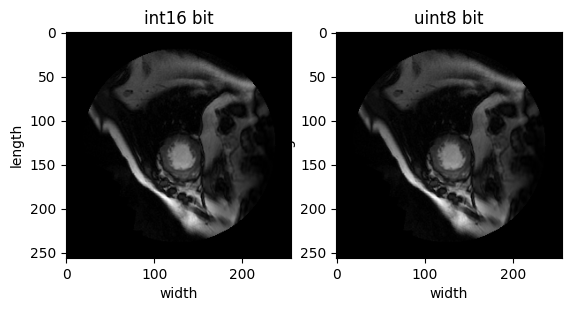

In [270]:
# read the dcm image
dicom_image = pydicom.dcmread(img_ex_filepath)

# extract the pixel data and convert to 8 bit image
image = img_as_ubyte (dicom_image.pixel_array / np.max(dicom_image.pixel_array))

fig, ax = plt.subplots(1,2)
ax[0].imshow(dicom_image.pixel_array, cmap="gray", vmin = np.min(dicom_image.pixel_array), vmax=np.max(dicom_image.pixel_array))
ax[0].set(title=f"{dicom_image.pixel_array.dtype} bit", xlabel='width', ylabel='length')

ax[1].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[1].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')
plt.show()

In [271]:
# # Dictionary to store optimal values
# optimal_values = {'disk_size': 1, 'sigma_blur': 0.2, 'clip_limit_val': 0.03, 'sigma_edge': 7.90, 'level_val': 0.8}

# # Define update function for disk size, sigma val, clip limit val, level val
# def update_image(disk_size, sigma_blur, clip_limit_val, sigma_edge, level_val):
#     optimal_values['disk_size'] = disk_size
#     optimal_values['sigma_blur'] = sigma_blur
#     optimal_values['clip_limit_val'] = clip_limit_val
#     optimal_values['sigma_edge'] = sigma_edge
#     optimal_values['level_val'] = level_val


#   # Image blurring procedure using sigma_val_blur
#     image_blurred_med = filters.median(image, morphology.disk(disk_size))
#     image_blurred_gaus = filters.gaussian(image, sigma=sigma_blur)

#     fig, ax = plt.subplots(2,5, figsize=(20, 10))

#     ax[0,0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
#     ax[0,0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

#     ax[0,1].imshow(image_blurred_med, cmap='gray', vmin=np.min(image_blurred_med), vmax=np.max(image_blurred_med))
#     ax[0,1].set(title=f"Median filter", xlabel='width', ylabel='length')

#     ax[1,1].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
#     ax[1,1].set(title=f"Gaussian filter", xlabel='width', ylabel='length')
#     ax[1,0].axis('off')

#   # Image contrast procedure using clip limit val
#     img_contrast_med = exposure.equalize_adapthist(image_blurred_med, clip_limit=clip_limit_val)
#     img_contrast_gaus = exposure.equalize_adapthist(image_blurred_gaus, clip_limit=clip_limit_val)

#     ax[0,2].imshow(img_contrast_med, cmap='gray', vmin=np.min(img_contrast_med), vmax=np.max(img_contrast_med))
#     ax[0,2].set(title=f"Contrast", xlabel='width', ylabel='length')


#     ax[1,2].imshow(img_contrast_gaus, cmap='gray', vmin=np.min(img_contrast_gaus), vmax=np.max(img_contrast_gaus))
#     ax[1,2].set(title=f"Contrast", xlabel='width', ylabel='length')

#   # Getting edges usign sigma_edge
#     edges_gaus = canny(img_contrast_gaus, sigma=sigma_edge)
#     edges_med = canny(img_contrast_med, sigma=sigma_edge)

#     ax[0,3].imshow(edges_med, cmap='gray', vmin=np.min(edges_med), vmax=np.max(edges_med))
#     ax[0,3].set(title=f"Edge detection", xlabel='width', ylabel='length')

#     ax[1,3].imshow(edges_gaus, cmap='gray', vmin=np.min(edges_gaus), vmax=np.max(edges_gaus))
#     ax[1,3].set(title=f"Edge detection", xlabel='width', ylabel='length')

#   # Getting contours
#     contours_gaus = measure.find_contours(edges_gaus, level=level_val)
#     contours_med = measure.find_contours(edges_med, level=level_val)

#     # fig, ax = plt.subplots()
#     ax[1,4].imshow(img_contrast_gaus, cmap='gray')
#     for contour in contours_gaus:
#         ax[1,4].plot(contour[:, 1], contour[:, 0], color='r', linewidth=2)  # Red contours
#     ax[1,4].set_title(f"Contours: {len(contours_gaus)}")

#     ax[0,4].imshow(img_contrast_med, cmap='gray')
#     for contour in contours_med:
#         ax[0,4].plot(contour[:, 1], contour[:, 0], color='r', linewidth=2)  # Red contours

#     ax[0,4].set_title(f"Contours: {len(contours_med)}")

#     plt.tight_layout()
#     plt.show()

# # Create sliders
# disk_size_slider = widgets.IntSlider(min=1, max=10, step=1, value=1, description='Disk Size:')
# sigma_blur_slider = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=0.2, description='Sigma Blur:')
# clip_limit_slider = widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=0.03, description='Clip Limit:')
# sigma_edge_slider = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=0.2, description='Sigma Edge:')
# level_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.8, description='Level:')

# # Interactive output with all sliders
# widgets.interactive(update_image,
#                     disk_size=disk_size_slider,
#                     sigma_blur=sigma_blur_slider,
#                     clip_limit_val=clip_limit_slider,
#                     sigma_edge=sigma_edge_slider,
#                     level_val=level_slider)


Extract pixel spacing that might be needed later

In [272]:
# pixel spacing
pixel_spacing = dicom_image.PixelSpacing
slice_thickness = dicom_image.SliceThickness if 'SliceThickness' in dicom_image else 1

In [273]:
# Optimal parameters
disk_size = 1
sigma_blur = 0.2
clip_limit_val = 0.03
sigma_edge = 7.00
level_val = 0.7

Filter out the noise from the image using gaussian or median filters

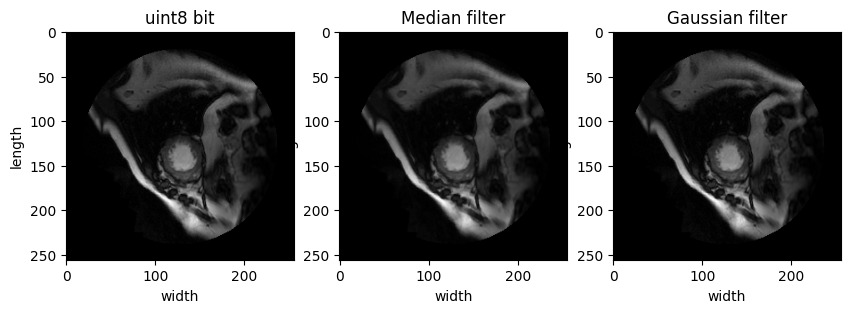

In [274]:

image_blurred_med = filters.median(image, morphology.disk(disk_size))
image_blurred_gaus = filters.gaussian(image, sigma=sigma_blur)

fig, ax = plt.subplots(1,3, figsize=(10, 5))

ax[0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

ax[1].imshow(image_blurred_med, cmap='gray', vmin=np.min(image_blurred_med), vmax=np.max(image_blurred_med))
ax[1].set(title=f"Median filter", xlabel='width', ylabel='length')

ax[2].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
ax[2].set(title=f"Gaussian filter", xlabel='width', ylabel='length')

plt.show()

Enhance contract using CLAHE (contrast limited adaptive histogram equalization)

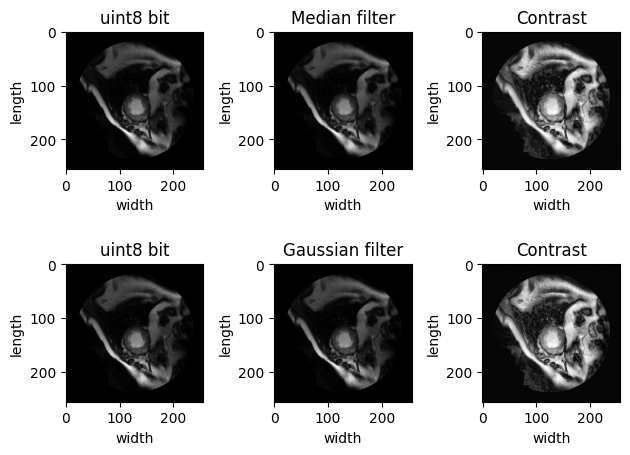

In [275]:
img_contrast_med = exposure.equalize_adapthist(image_blurred_med, clip_limit=clip_limit_val)
img_contrast_gaus = exposure.equalize_adapthist(image_blurred_gaus, clip_limit=clip_limit_val)

fig, ax = plt.subplots(2,3)

ax[0,0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[0,0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

ax[0,1].imshow(image_blurred_med, cmap='gray', vmin=np.min(image_blurred_med), vmax=np.max(image_blurred_med))
ax[0,1].set(title=f"Median filter", xlabel='width', ylabel='length')

ax[0,2].imshow(img_contrast_med, cmap='gray', vmin=np.min(img_contrast_med), vmax=np.max(img_contrast_med))
ax[0,2].set(title=f"Contrast", xlabel='width', ylabel='length')



ax[1,0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[1,0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')


ax[1,1].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
ax[1,1].set(title=f"Gaussian filter", xlabel='width', ylabel='length')

ax[1,2].imshow(img_contrast_gaus, cmap='gray', vmin=np.min(img_contrast_gaus), vmax=np.max(img_contrast_gaus))
ax[1,2].set(title=f"Contrast", xlabel='width', ylabel='length')

plt.tight_layout()
plt.show()

As we can see in the above results, both gaussian and median filters provide good results. I will continue with gaussian filtering.

Edge detection with Canny function

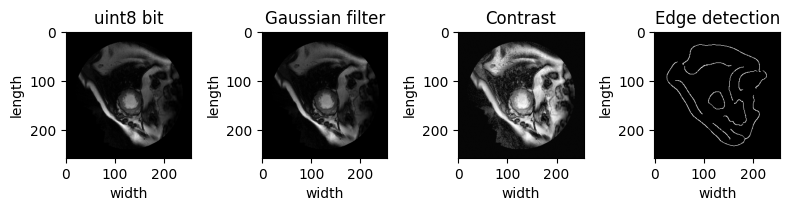

In [276]:
edges_gaus = canny(img_contrast_gaus, sigma=sigma_edge)

fig, ax = plt.subplots(1, 4, figsize=(8, 8))

ax[0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

ax[1].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
ax[1].set(title=f"Gaussian filter", xlabel='width', ylabel='length')

ax[2].imshow(img_contrast_gaus, cmap='gray', vmin=np.min(img_contrast_gaus), vmax=np.max(img_contrast_gaus))
ax[2].set(title=f"Contrast", xlabel='width', ylabel='length')

ax[3].imshow(edges_gaus, cmap='gray', vmin=np.min(edges_gaus), vmax=np.max(edges_gaus))
ax[3].set(title=f"Edge detection", xlabel='width', ylabel='length')

plt.tight_layout()
plt.show()

Find and draw the contours

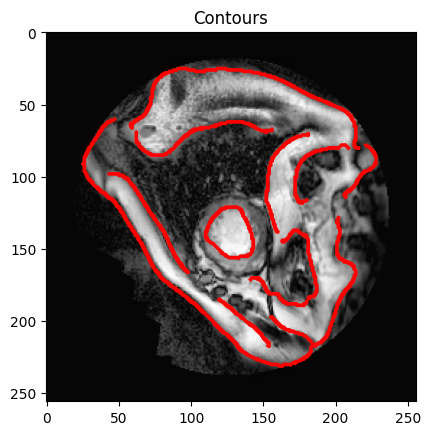

In [277]:
contours = measure.find_contours(edges_gaus, level=level_val)

fig, ax = plt.subplots()
ax.imshow(img_contrast_gaus, cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], color='r', linewidth=2)  # Red contours
ax.set_title("Contours")
plt.show()


As we can see, the ventricle does get enclosed but there are a lot of other things as well. I will try to extract the circles in the edge detected image.

Create a binary mask with contours being at the foreground

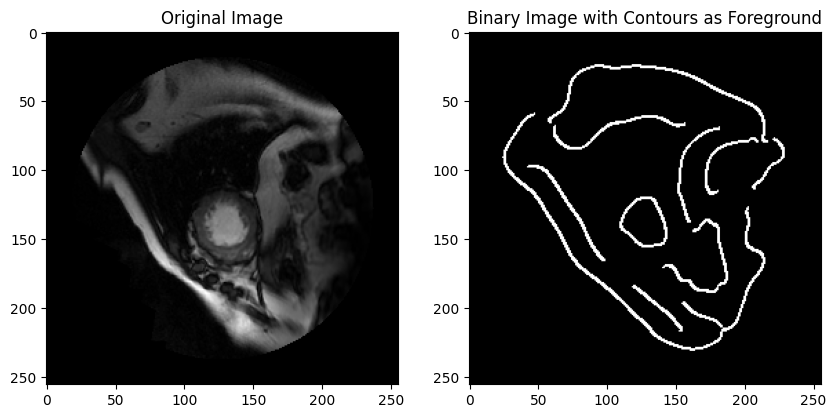

In [278]:

binary_contours_image = np.zeros_like(image, dtype=np.uint8)
for contour in contours:
    # Convert contour to polygon coordinates and fill it in the binary image
    contour_points = contour.astype(int)
    rr, cc = polygon(contour_points[:, 0], contour_points[:, 1], shape=binary_contours_image.shape)
    binary_contours_image[rr, cc] = 255  # Set contour area to foreground (255)

# Step 6: Visualize the result
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=np.min(image), vmax=np.max(image))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_contours_image, cmap='gray')
plt.title("Binary Image with Contours as Foreground")

plt.show()

I will find labels in the binary mask, measure region properties and evaluate eccentricity of every region.

In [279]:
labeled_image, num_labels = measure.label(binary_contours_image, connectivity=2, return_num=True)
print(f"Number of labels: {num_labels}")

regions = measure.regionprops(labeled_image)
# print(f"Number of regions: {len(regions)}")
# print(f"Region properties: {regions}")

smallest_eccentricity = float('inf')
smallest_eccentricity_region = None

for prop in regions:
    print(f"Region area: {prop.area}")
    # print(f"Region equivalent diameter are: {prop.equivalent_diameter_area}")
    print(f"Region eccentricity: {prop.eccentricity}\n")
    # print(f"Region centroid: {prop.centroid}")
    # print(f"Region perimeter: {prop.perimeter}")
    # print(f"Region perimeter crofton: {prop.perimeter_crofton}")
    # print(f"Region bbox: {prop.bbox}")
    # print(f"Region bbox area: {prop.bbox_area}")
    # print(f"Region orientation: {prop.orientation}")
    # print(f"Region solidity: {prop.solidity}")
    # print(f"Region bounding box: {prop.bbox} \n")

    if prop.eccentricity < smallest_eccentricity:
        smallest_eccentricity = prop.eccentricity
        smallest_eccentricity_region = prop

print(f"Smallest eccentricity: {smallest_eccentricity}")
print(f"Smallest eccentricity region: {smallest_eccentricity_region}")
#


Number of labels: 10
Region area: 477.0
Region eccentricity: 0.9629664791300707

Region area: 989.0
Region eccentricity: 0.9065313986582374

Region area: 258.0
Region eccentricity: 0.986795533656532

Region area: 181.0
Region eccentricity: 0.9665025046324408

Region area: 157.0
Region eccentricity: 0.9301934661616463

Region area: 108.0
Region eccentricity: 0.9742534533868635

Region area: 245.0
Region eccentricity: 0.9972089601499076

Region area: 238.0
Region eccentricity: 0.45115394359055944

Region area: 280.0
Region eccentricity: 0.7057020704946987

Region area: 132.0
Region eccentricity: 0.9975490889349297

Smallest eccentricity: 0.45115394359055944
Smallest eccentricity region: <skimage.measure._regionprops.RegionProperties object at 0x7adeff3f5210>


Using smallest eccentricity, which should coincide with left ventricle, let's obtain the mask for the left ventricle

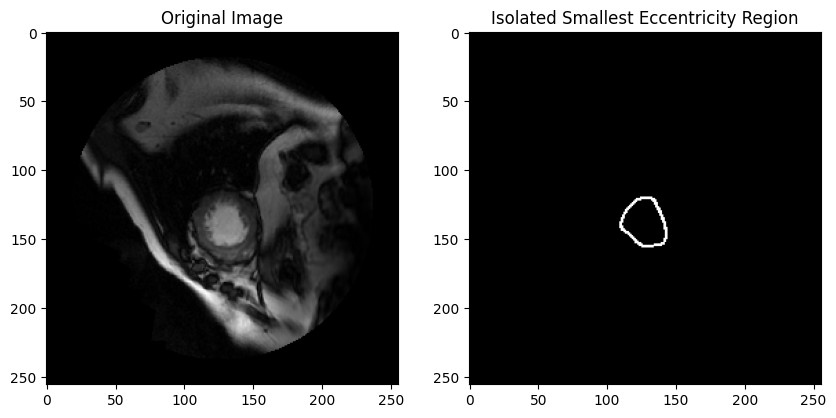

In [280]:
smallest_eccentricity_mask = np.zeros_like(labeled_image, dtype=np.uint8)
smallest_eccentricity_mask[labeled_image == smallest_eccentricity_region.label] = 255

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(smallest_eccentricity_mask, cmap='gray')
plt.title("Isolated Smallest Eccentricity Region")

plt.show()

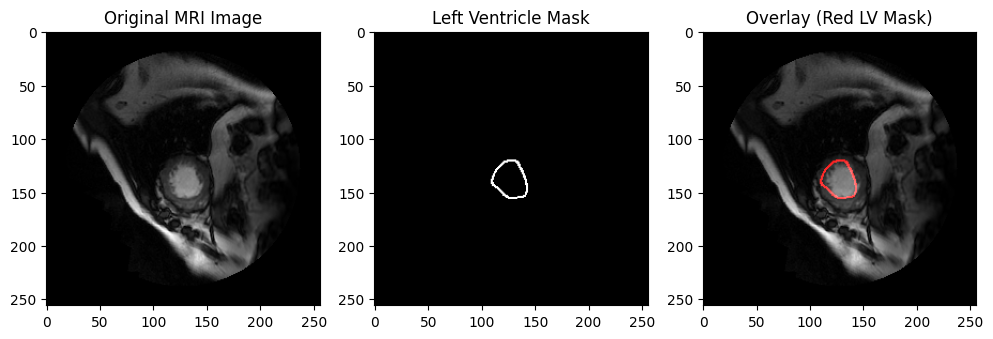

In [281]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize original image for proper display (optional)
image = image.astype(np.float32)
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1] range

# Create an RGB version of the grayscale image
image_rgb = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB (shape: HxWx3)

# Create a red-colored mask (overlay will be red where the mask is)
mask_rgb = np.zeros_like(image_rgb)  # Create an empty RGB image
mask_rgb[:, :, 0] = smallest_eccentricity_mask  # Red channel

# Alpha blending
alpha = 0.05  # Transparency level
overlay = (image_rgb * (1 - alpha) + mask_rgb * alpha)

# Ensure values are in valid range [0,1] for display
overlay = np.clip(overlay, 0, 1)

# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original MRI Image")

plt.subplot(1, 3, 2)
plt.imshow(smallest_eccentricity_mask, cmap='gray')
plt.title("Left Ventricle Mask")

plt.subplot(1, 3, 3)
plt.imshow(overlay, cmap='gray', vmin=np.min(overlay), vmax=np.max(overlay))
plt.title("Overlay (Red LV Mask)")

plt.show()


Consider 16 bit
Haft transform
Temporal component by subtracting consecutive frames from each other